In [1]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

Using TensorFlow backend.


In [2]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns
import re

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 54 s, sys: 8.26 s, total: 1min 2s
Wall time: 1min 2s


In [4]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

### take SRS descripitions for classification

In [5]:
%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
srsS=pd.read_pickle(inS_dir)
srsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),
                                                            srsS.index.get_level_values(1).str.lower()]) )

CPU times: user 39.4 s, sys: 8.27 s, total: 47.6 s
Wall time: 47.6 s


In [6]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

In [7]:
noDupSampleS=technical_meta_data_df.groupby(['Study']).head(n=1)['Sample']

In [8]:
specie_m=srsS.isin(['Mus musculus','Homo sapiens'])

In [9]:
attrib_m=srsS.index.get_level_values(1)=='scientific_name'

In [10]:
mySpecieSrs=srsS[specie_m&attrib_m].index.get_level_values(0).unique()

In [11]:
specie_srs_m=srsS.index.get_level_values(0).isin(mySpecieSrs)

In [12]:
attrib_a=srsS.index.get_level_values(1)
attrib_m=attrib_a=='description'


In [13]:
oneInStudy_m=srsS.index.get_level_values(0).isin(noDupSampleS.values)

In [466]:
srsS_sub=srsS[attrib_m&specie_srs_m&oneInStudy_m].drop_duplicates()

#make sure the code doesn't sample from outliers
#20 words https://www.ijcai.org/proceedings/2017/0578.pdf
wordCountS=srsS_sub.str.count(' ')
lem_m=(wordCountS<=60)&(wordCountS>=10)
srsS_sub=srsS_sub[lem_m]

In [468]:
inTestStrS=srsS_sub.sample(n=100,random_state=0)

### reload model

In [469]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')

%time model=load_model('./model/lstm.h5')

KeyboardInterrupt: 

#### get baseline empty state

In [470]:
val_docs = list(nlp.pipe(' '))
val_X=get_features(val_docs,max_length=model.input_shape[1])

emptyState=model.predict_proba(val_X)[0,:]

### calculate NER score for each segment

In [471]:
import nltk
from nltk.corpus import stopwords


In [472]:
stopWords=stopwords.words('english')

In [574]:
phraseMax=7

In [625]:
myML=[]
myKeyL=[]
for i_th,sent in enumerate(tqdm(inTestStrS)):
    sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
    tokens=re.split(pattern=' ',string=sent)
    tokens=list(filter(lambda token:(token!='') and (token not in stopWords) ,tokens))
    ###keep track of each token
    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
    #for n_gram in range(1,len(tokens)+1):
    myNMax=min( [len(tokens),phraseMax])
    #print (myNMax)
    for n_gram in range(1,myNMax):
        
        grams=list(map(lambda L:" ".join(L),list(ngrams(tokens,n_gram))))
        val_docs = list(nlp.pipe(grams))
        val_X=get_features(val_docs,max_length=model.input_shape[1])
        predictM=model.predict_proba(val_X)
        tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
        empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.1
        moreThanTwoValToken_mask=(val_X!=0).sum(axis=1)>=2
        tmpDf[empty_mask&moreThanTwoValToken_mask]=0
        
        for i,gram in enumerate(tmpDf.index):
            #for j,one_gram in enumerate(gram.split(' ')):
            myKeyL.append((i_th,sent,n_gram,i,gram)) 
            myML.append(tmpDf.iloc[i])
                #(tmpDf.iloc[i])
        
        #tmpDf2=tmpDf[(tmpDf>=0.5).any(axis=1)]
        

        #update score in table by 
        #for i,gram in enumerate(tmpDf.index):# for each n-gram, #for each word add the score
        #        for j,one_gram in enumerate(gram.split(' ')): #check the score of each split compared to current ones
        #                scoreDf.iloc[i+j]=scoreDf.iloc[i+j]+(tmpDf.iloc[i])
        #                #scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
        
    #if i_th>10:
    #    break

100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


In [626]:
tmpDf.iloc[i]

SCIENTIFIC_NAME    0.000202
cell type          0.117871
disease            0.000767
genotype           0.032180
geo_loc_name       0.000011
sex                0.000009
Name: mRNA translation heatshock condition m6A modification, dtype: float32

In [627]:
#
tmpDf.iloc[i]

SCIENTIFIC_NAME    0.000202
cell type          0.117871
disease            0.000767
genotype           0.032180
geo_loc_name       0.000011
sex                0.000009
Name: mRNA translation heatshock condition m6A modification, dtype: float32

In [628]:
thresholdS=pd.Series(
   {'SCIENTIFIC_NAME': 0.26689231395721436,
 'cell type': 0.10027739964425564,
 'disease': 0.15823280811309814,
 'genotype': 0.09954400360584259,
 'geo_loc_name': 0.6163255572319031,
 'sex': 0.6458048224449158}
)

In [629]:
#myML

In [630]:
mergedDf=pd.concat(myML,keys=myKeyL,axis=1).T

In [631]:
mergedDf.index.names=['i_thSrs','orig_text','n','i','token']

In [632]:
#mergedDf

In [633]:
n_threshold=2

In [634]:
mergedDf_sub=mergedDf[mergedDf.index.get_level_values('n')>=n_threshold]

In [635]:
#(mergedDf_sub>thresholdS)

In [636]:
m_val=(mergedDf_sub>thresholdS).sum(axis=1)>=1

In [637]:
#mergedDf_sub.columns.names=['Predicted_NE']

In [638]:
VC=mergedDf_sub[m_val].idxmax(axis=1).groupby(['i_thSrs','orig_text','i','token']).value_counts()

In [639]:
myNameL=list(VC.index.names)
myNameL[-1]='Predicted_NE'
VC.index.names=myNameL

In [640]:
#### for each n-gram, there is the same start site, use 

In [641]:
#VC

In [642]:
VC.to_frame().reset_index().drop_duplicates(['orig_text','Predicted_NE'])

,i_thSrs,orig_text,i,token,Predicted_NE,0
0,0,This individual is a 69 year old male of South...,0,This individual,sex,1
1,0,This individual is a 69 year old male of South...,6,South Asian origin Country Birth India,geo_loc_name,1
4,1,WT with stable insertion of a cassette for pro...,0,WT stable,genotype,1
22,1,WT with stable insertion of a cassette for pro...,6,target short,sex,1
24,1,WT with stable insertion of a cassette for pro...,8,hairpin RNA,cell type,1
25,2,DNA damage induced by etoposide and hydroxyure...,0,DNA damage,cell type,1
39,2,DNA damage induced by etoposide and hydroxyure...,5,modulates gene,genotype,1
48,3,Protocols Cells were treated with 10 ng ml TN...,0,Protocols Cells,cell type,1
52,3,Protocols Cells were treated with 10 ng ml TN...,11,generated inverse,sex,1
53,3,Protocols Cells were treated with 10 ng ml TN...,16,already carrying,genotype,1


In [621]:
#mergedDf
#take on any length, 

In [247]:
tmpDf=(mergedDf>thresholdS).loc['ESCs WT replicate1 mRNA Mad2l2'].stack().reset_index()

KeyError: 'the label [ESCs WT replicate1 mRNA Mad2l2] is not in the [index]'

In [120]:
tmpDf.columns=['n','n-gram','attrib','passThreshold']

In [124]:
#tmpDf['n-gram']

In [122]:
tmpDf[tmpDf.passThreshold]
      

,n,n-gram,attrib,passThreshold
1,1,ESCs,cell type,True
9,1,WT,genotype,True
15,1,replicate1,genotype,True
21,1,mRNA,genotype,True
25,1,Mad2l2,cell type,True
27,1,Mad2l2,genotype,True
39,2,WT replicate1,genotype,True
45,2,replicate1 mRNA,genotype,True
51,2,mRNA Mad2l2,genotype,True
63,3,WT replicate1 mRNA,genotype,True


In [112]:
tmpS[tmpS].groupby(level=[1,2]).size()

n-gram                              
ESCs                       cell type    1
Mad2l2                     cell type    1
                           genotype     1
WT                         genotype     1
WT replicate1              genotype     1
WT replicate1 mRNA         genotype     1
WT replicate1 mRNA Mad2l2  genotype     1
mRNA                       genotype     1
mRNA Mad2l2                genotype     1
replicate1                 genotype     1
replicate1 mRNA            genotype     1
replicate1 mRNA Mad2l2     genotype     1
dtype: int64

In [27]:
tmpDf2.idxmax(axis=1)

double             genotype
strand            cell type
breaks      SCIENTIFIC_NAME
captured                sex
by                      sex
see                genotype
pmid        SCIENTIFIC_NAME
dtype: object

In [77]:
mergedDf=pd.concat(myML,keys=list(inTestStrS))

In [78]:
numeric_token_m=mergedDf.index.get_level_values(0).str.contains('^\d+$')

In [79]:
mergedSubDf=mergedDf[~numeric_token_m].copy()#.loc[:,mergedDf.columns!='age']

In [80]:
threshold=0.800000
mergedSubDf['undetected']=threshold
#noAmbigM=(mergedSubDf>=threshold).sum(axis=1)>=1 #this mark screw up the confoudning boundary 
mergedSubDf.loc[:,'undetected']=threshold

In [81]:
predDf=mergedSubDf.idxmax(axis=1).to_frame()

In [82]:
predDf.index.names=['Freetext','Token']
predDf['token_numeric']=predDf.index.get_level_values('Token').str.contains('^\d+$')

In [50]:
excel=pd.ExcelWriter('./Results/for_curation.xlsx')
predDf[~predDf['token_numeric']].to_excel(excel)
excel.close()

# scratch

In [ ]:
asdasd

In [83]:
predDf[~predDf['token_numeric']]

0  \
Freetext                                           Token                        
Chipseq & rnaseq                                   chipseq         undetected   
                                                   rnaseq          undetected   
parental cell line                                 parental        undetected   
                                                   cell             cell type   
                                                   line            undetected   
MPRA RNA-seq from K562 cells                       mpra            undetected   
                                                   rna              cell type   
                                                   seq             undetected   
                                                   from            undetected   
                                                   k562             cell type   
                                                   cells            cell type   
RNA-seq of total RNA from Z/Edn2; Six3-Cre mous... rna             undetected   
                                                   seq             undetected   
                                                   of              undetected   
                                                   total           undetected   
                                                   rna              cell type   
                                                   from             cell type   
                                                   z                 genotype   
                                                   edn2              genotype   
                                                   six3              genotype   
                                                   cre               genotype   
                                                   mouse           undetected   
                                                   retina          undetected   
Human HapMap individual NA18500                    human           undetected   
                                                   hapmap          undetected   
                                                   individual             sex   
                                                   na18500         undetected   
mRNA; raw sequence read; Illumina HiSeq2000 pla... mrna            undetected   
                                                   raw             undetected   
                                                   sequence        undetected   
...                                                                       ...   
Well differentiated endometrial adenocarcinoma ... endometrial      cell type   
                                                   adenocarcinoma   cell type   
                                                   cell             cell type   
                                                   line             cell type   
                                                   from             cell type   
                                                   a                cell type   
                                                   year             cell type   
                                                   old              cell type   
                                                   woman            cell type   
                                                   estrogen         cell type   
                                                   and              cell type   
                                                   progesterone     cell type   
                                                   receptors         genotype   
                                                   positive          genotype   
naive CD4 positive T cells from BF_T cell_WGBS1... naive           undetected   
                                                   cd4              cell type   
                                                   positive         cell type   
                          

In [ ]:
!echo $PWD/./Results/for_curation.xlsx

In [ ]:
#predDf

In [ ]:
!echo $PWD/./Results/for_curation.xlsx

In [ ]:
predDf[~predDf['token_numeric']].to_csv('tmp.csv')

In [ ]:
#!rm tmp.csv

In [ ]:
import numpy as np

In [ ]:
#replace with duplicated states
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])

In [ ]:
emptyState=mergedSubDf.groupby(mergedSubDf.columns.tolist(),as_index=False).size().sort_values().index[-1]
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])
print (emptyState)

In [ ]:
noPredM=((mergedSubDf-emptyState).abs()<0.1).all(axis=1)
mergedSubDf[(~noPredM)&(mergedSubDf>0.5).sum(axis=1)==1]

In [ ]:
#good examples: HAP1 LMTK3-KO cells, stimulated with WNT3, replicate R2

In [ ]:
mergedSubDf.loc['HAP1 CCK4-KO cells, stimulated with RESV, replicate R1']

In [ ]:
mergedSubDf[].iloc[0].values

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
##among the ones with >0.5, take the ones that are unique
sns.heatmap(data=(scoreDf>0.6).T)

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
### among the ones with clear boundry, it can classify well. 


"""
argue that it can salvage the data correctly. Among those sentences, 

take >0.5 as boundary, run top 10000 sentences 
"""
scoreDf

### show one

In [89]:
#sent='Human histone H3 di-methylated at lysine 4 (H3K4me2) in human blood CD4+ T cells, targeted using Abcam antibody ab7766'#inTestStrS.iloc[5]
sent='RNA-seq of total RNA from Z/Edn2; Six3-Cre mouse retina	'
print(sent)

RNA-seq of total RNA from Z/Edn2; Six3-Cre mouse retina	


"break\n\n#each n gram only advange \nfor i,gram in enumerate(tmpDf.index):# for ec\n    for j,one_gram in enumerate(gram.split(' ')):\n        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))\n"

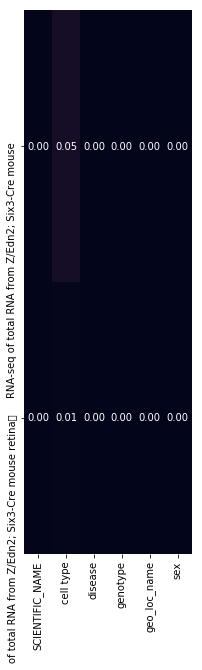

In [94]:
#sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
#for n_gram in range(1,len(tokens)):
n_gram=8
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
#print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,max_length=model.input_shape[1])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
#tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
tmpDf[empty_mask]=0

fig,ax=plt.subplots(figsize=(3,2.5*4))
sns.heatmap(tmpDf,annot=True,ax=ax,vmin=0,vmax=1.0,fmt='.2f',cbar=None)
#ax.set_xticklabels([])
"""break

#each n gram only advange 
for i,gram in enumerate(tmpDf.index):# for ec
    for j,one_gram in enumerate(gram.split(' ')):
        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
"""

In [88]:
#for each one, makes a prediction on the term, to see what it is supposed to be. 

### test one

In [ ]:
sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    predictM=model.predict_proba(val_X)

    tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
    empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
    tmpDf[empty_mask]=0

    """
    each n gram only advange 
    """
    for i,gram in enumerate(tmpDf.index):# for ec
        for j,one_gram in enumerate(gram.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))


In [ ]:
threshold=0.2
scoreDf[scoreDf<=threshold]=0
scoreDf['undetected']=threshold

scoreDf.idxmax(axis=1)

In [ ]:
sns.heatmap(scoreDf,annot=True)

In [ ]:
tokens

In [ ]:
sns.heatmap(scoreDf.T,annot=True)

In [ ]:
sexS=srsS[srsS.index.get_level_values(1)=='sex']

In [ ]:
sexS.value_counts()

In [644]:
tmpSubSrsS1=srsS[srsS.str.contains('rna',case=False)]

In [645]:
tmpSubSrsS1

SRS1024493  description                   Leaf samples were collected from flowering wil...
ERS1412828  title                                                      Malawi2016RNA6599630
            sample_description                                                    total RNA
DRS014254   description                   RNAseq of total RNA from head of larval female...
ERS039842   description                   Protocols: RNA was extracted from the worms us...
ERS039843   description                   Protocols: RNA was extracted from the worms us...
SRS115245   title                                                   WT_total RNA minus rRNA
SRS115246   title                                                  YQH_total RNA minus rRNA
SRS1098402  sample_type                                                           Total RNA
SRS1098466  sample_type                                                           Total RNA
SRS1098467  sample_type                                                         